#### augmentation for the Unet structure. Applied in the LM dataset

In [1]:
# check the status of GPU
from tensorflow.python.client import device_lib

local_device_protos = device_lib.list_local_devices()

[print(x) for x in local_device_protos if x.device_type == 'GPU']

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 32503955456
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14317926851015356491
physical_device_desc: "device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:61:00.0, compute capability: 7.0"



2022-08-24 10:32:01.825086: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-24 10:32:02.472226: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 30998 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:61:00.0, compute capability: 7.0


[None]

In [2]:
# define if the documenting process should go on

DOCUMENT = True
# DOCUMENT = False
TRAIN = 300 # training epochs num

In [3]:
# neptune document

import neptune.new as neptune
from neptune.new.integrations.tensorflow_keras import NeptuneCallback

if DOCUMENT:

    run = neptune.init(
        project="leeleeroy/LM-2D-Unet",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjVjOGVmZi04MjA4LTQ4N2QtOWIzYy05M2YyZWI1NzY3MmEifQ==",
        name = "UNet2D_64_vanilla",
    ) # necessary credentials, the name could be used to reproduce the results 

    # for callbacks in training



    neptune_cbk = NeptuneCallback(run=run, base_namespace='metrics')  # neptune for the training process
    
    # neptune document the hyper param.

    PARAMS = {
              "optimizer": {"learning_rate": 0.001, "beta_1":0.9,"optimizer": "Adam"},
              'epochs': TRAIN,
              'batch_size':8}

    # log hyper-parameters
    run['hyper-parameters'] = PARAMS
    run["sys/tags"].add(["vanilla", "val", "binary", "epochs:" + str(TRAIN)])


/home/li52/.conda/envs/LM/lib/python3.7/site-packages/neptune/new/internal/utils/git.py:35: UserWarning: GitPython could not be initialized
  warnings.warn("GitPython could not be initialized")
/home/li52/.conda/envs/LM/lib/python3.7/site-packages/neptune/new/internal/utils/git.py:35: UserWarning: GitPython could not be initialized
  warnings.warn("GitPython could not be initialized")


https://app.neptune.ai/leeleeroy/LM-2D-Unet/e/LMDUN-34
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


#### load in the data

In [4]:
# data loading 

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import os
import pandas as pd
import random

In [5]:
# visualization for two images

def subShow(IMG1, IMG2):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(IMG1, cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(IMG2, cmap='gray')
    plt.show()

In [6]:
PATH = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_partial_15/'

Mask = np.load(PATH + 'biMasks15.npy')
IMG = np.load(PATH + 'rawGray15.npy')

Mask = Mask.reshape(-1, 1040, 1392)  # flatten into images 
IMG = IMG.reshape(-1, 1040, 1392)

Mask = Mask[...,176:(176+Mask.shape[1])]  # crop for later scaling
IMG = IMG[...,176:(176+IMG.shape[1])]

print('Mask info: ', Mask.shape, Mask.dtype)
print('Image info: ', IMG.shape, IMG.dtype)

Mask info:  (300, 1040, 1040) uint8
Image info:  (300, 1040, 1040) uint8


In [7]:
# resize the images

from skimage.transform import resize

SIZE = [256, 256]
totalIMG = Mask.shape[0]
numIMG = 250

smallIMG = resize(IMG[:numIMG,...], (numIMG,SIZE[0],SIZE[1]), anti_aliasing=True)
smallIMG = np.interp(smallIMG, (smallIMG.min(), smallIMG.max()), (0, 1))  # rescale the img

smallMask = resize(Mask[:numIMG,...].astype(bool), (numIMG,SIZE[0],SIZE[1]), anti_aliasing=False)
smallMask = smallMask.astype(int)

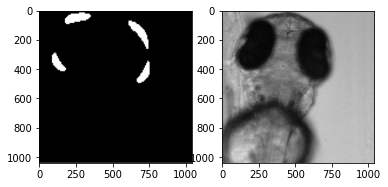

In [8]:
# sanity check

NUM = 100

subShow(Mask[NUM,...], IMG[NUM,...])

In [9]:
# patchify the images
from patchify import patchify, unpatchify

def rawPatch(imageStack,patchPara):
    all_img_patches = []

    for img in range(imageStack.shape[0]):
        large_image = imageStack[img]

        patches_img = patchify(large_image, (patchPara['x'],patchPara['y']), step=patchPara['step'])  # no overlap

        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):

                single_patch_img = patches_img[i,j,:,:]
                # transform the image if the type is not correct
                if single_patch_img.dtype == 'uint8':
                    single_patch_img = (single_patch_img.astype('float32')) / 255.  # remember to standarize into 0-1
                    
                all_img_patches.append(single_patch_img)
    
    return all_img_patches, patches_img.shape

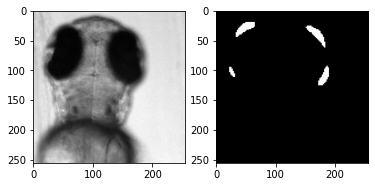

img: (250, 256, 256) float64
mask: (250, 256, 256) int64
img range: 1.0 0.0
mask range: 1 0


In [10]:
# sanity check for the resized data

subShow(smallIMG[0,...], smallMask[0,...])

print('img:',smallIMG.shape, smallIMG.dtype)
print('mask:',smallMask.shape, smallMask.dtype)

print('img range:', np.max(smallIMG), np.min(smallIMG))
print('mask range:', np.max(smallMask), np.min(smallMask))

In [11]:
# preporcessing the data into patches

# train dataset
patchPara = {'x': 256, 'y': 256, 'step':256}

X_patches, _ =  rawPatch(smallIMG, patchPara); X_patches = np.stack((X_patches,)*3, axis=-1)
Y_masks, _ = rawPatch(smallMask, patchPara); Y_masks = np.expand_dims(Y_masks, -1)

In [12]:
# check the data properties

print('patches shape:',X_patches.shape, X_patches.dtype)
print('mask shape:',Y_masks.shape, Y_masks.dtype)
print(np.max(Y_masks[0,...]), np.min(Y_masks[0,...]))
print(np.max(X_patches[0,...]), np.min(X_patches[0,...]))

patches shape: (250, 256, 256, 3) float64
mask shape: (250, 256, 256, 1) int64
1 0
0.40549308236637466 0.0029438465615517144


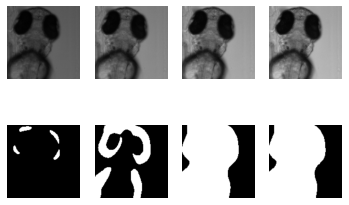

In [13]:
#  sanity check for the mask and images

startNum = 100
n_samples = 4

for i in range(n_samples):
    plt.subplot(2, n_samples, 1+i)
    plt.axis('off')
    plt.imshow(X_patches[int(i+startNum)], cmap='gray')
    
for i in range(n_samples):
    plt.subplot(2, n_samples, 1+n_samples+i)
    plt.axis('off')
    plt.imshow(Y_masks[int(i+startNum)], cmap='gray')    
plt.show()

#### Prepare the model

In [14]:
# Unet structure in blocks
import tensorflow.keras as k

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam  # ! notice here must write in tensorflow.keras
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)  #Binary (can be multiclass)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [15]:
# loss function

import segmentation_models as sm

# loss function
# loss
BCE_loss = sm.losses.BinaryCELoss()
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.5,0.5]))
focal_loss = sm.losses.CategoricalFocalLoss()
# jaccard_loss = sm.losses.bce_jaccard_loss()

# total_loss = dice_loss*0.005 + (1* focal_loss) + BCE_loss*1
# total_loss = dice_loss*1 + ( focal_loss*1) + BCE_loss*0.005
total_loss = dice_loss*0.05 + (0.5* focal_loss) + BCE_loss*0.95

Segmentation Models: using `keras` framework.


In [16]:
# compile the model
from tensorflow.keras.optimizers import Adam
import segmentation_models as sm


IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = build_unet(input_shape)
# model.compile(optimizer=Adam(lr = 1e-3), loss='binary_crossentropy', metrics=['accuracy', sm.metrics.IOUScore(threshold=0.5)])  # add Adam from Keras, not tensorflow.adam
model.compile(optimizer=Adam(lr = 1e-3), loss=total_loss, metrics=['accuracy', sm.metrics.IOUScore(threshold=0.5),sm.metrics.FScore(threshold=0.5)])

# model.summary()

2022-08-24 10:32:14.861291: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30998 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:61:00.0, compute capability: 7.0
/home/li52/.conda/envs/LM/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


#### Realize the model for training

In [17]:
from sklearn.model_selection import train_test_split

images = X_patches
masks = Y_masks

X_train, X_val, Y_train, Y_val = train_test_split(images, masks, test_size = 0.25, random_state = 42)

# X_train = Xtrain_patches; Y_train = Ytrain_patches;
# X_test = Xtest_patches; Y_test = Ytest_patches;


In [18]:
# data augmentation

seed=24  # gurantee the images and masks are the same with augmentaion
from keras.preprocessing.image import ImageDataGenerator

# dictionary for augmentation
img_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect',)
                     # preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) 
#Binarize the output again. Because the new-generated images comes with interperated values

image_data_generator = ImageDataGenerator(**img_data_gen_args)


batch_size= 8  # 16 will dead


In [19]:
# Data generator

image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)  # relevant to normalization

image_generator = image_data_generator.flow(X_train, seed=seed)
valid_img_generator = image_data_generator.flow(X_val, seed=seed)

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(Y_train, augment=True, seed=seed)
mask_generator = mask_data_generator.flow(Y_train, seed=seed)
valid_mask_generator = mask_data_generator.flow(Y_val, seed=seed)

In [20]:
# pack the two generators together

def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

In [21]:
# generator

my_generator = my_image_mask_generator(image_generator, mask_generator)  # give out the image generator and mask at teh same time

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)

x = image_generator.next()
y = mask_generator.next()

#### Train the model

In [22]:
import tensorflow.keras as k

if DOCUMENT:
    callbacks = [
        # k.callbacks.EarlyStopping(patience=15, monitor='val_loss'),
        neptune_cbk, 
        k.callbacks.TensorBoard(log_dir = './Unet/tensorBoard')  # save in new folder in hemera. Also update in neptune
    ]
else:
    callbacks = [
        # k.callbacks.EarlyStopping(patience=15, monitor='val_loss'),
        k.callbacks.TensorBoard(log_dir = './Unet/tensorBoard')  # save in new folder in hemera. Also update in neptune
    ]

2022-08-24 10:32:19.128917: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-08-24 10:32:19.129027: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-08-24 10:32:19.129094: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-08-24 10:32:19.129533: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /trinity/shared/pkg/numlib/mpfr/3.1.4/lib:/trinity/shared/pkg/numlib/mpc/1.0.3/lib:/trinity/shared/pkg/numlib/gmp/6.1.2/lib:/trinity/shared/pkg/compiler/gcc/7.3.0/lib64:/trinity/shared/pkg/compiler/gcc/7.3.0/lib:/trinity/shared/pkg/devel/cuda/11.2/lib64:/trinity/shared/pkg/devel/cuda/11.2/lib:/trinity/shared/pkg/devel/anaconda/2021.11/lib:/trinity/shared/pkg/devel/python/3.10.4/lib/python3.10:/trinity/shared/pkg/d

In [ ]:
# define the hyper param

import tensorflow.keras as k
steps_per_epoch = 3*(len(X_train))//batch_size  # depend on the training dataset

# callbacks = [
#     #k.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
#     neptune_cbk,
#     k.callbacks.TensorBoard(log_dir = 'logsAugH')
# ]

history = model.fit_generator(my_generator, validation_data=validation_datagen, 
                    steps_per_epoch=steps_per_epoch, 
                    validation_steps=steps_per_epoch, epochs=TRAIN, callbacks=callbacks)  # use the model from blocks build

/home/li52/.conda/envs/LM/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-08-24 10:32:19.653163: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/300


2022-08-24 10:32:22.692697: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


 1/70 [..............................] - ETA: 12:11 - loss: 0.9612 - accuracy: 0.4536 - iou_score: 0.2405 - f1-score: 0.3877

2022-08-24 10:32:30.332945: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-08-24 10:32:30.332982: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-08-24 10:32:30.333105: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1666] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.


 2/70 [..............................] - ETA: 38s - loss: 0.8908 - accuracy: 0.5683 - iou_score: 0.4169 - f1-score: 0.5662  

2022-08-24 10:32:30.845248: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-08-24 10:32:30.848476: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1757] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.
2022-08-24 10:32:30.859150: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-08-24 10:32:30.861977: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-08-24 10:32:30.873362: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./Unet/tensorBoard/train/plugins/profile/2022_08_24_10_32_30

2022-08-24 10:32:30.875632: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./Unet/tensorBoard/train/plugins/profile/2022_08_24_10_32_30/gv012.cluster.trace.json.gz
2022-08-24 10:32

70/70 [==============================] - 103s 1s/step - loss: 0.3333 - accuracy: 0.8657 - iou_score: 0.8143 - f1-score: 0.8921 - val_loss: 4.3682 - val_accuracy: 0.5398 - val_iou_score: 0.2516 - val_f1-score: 0.4018
Epoch 2/300
70/70 [==============================] - 88s 1s/step - loss: 0.2779 - accuracy: 0.9001 - iou_score: 0.8621 - f1-score: 0.9252 - val_loss: 8.7806 - val_accuracy: 0.3975 - val_iou_score: 1.8669e-06 - val_f1-score: 3.7335e-06
Epoch 3/300
70/70 [==============================] - 88s 1s/step - loss: 0.2753 - accuracy: 0.9013 - iou_score: 0.8637 - f1-score: 0.9258 - val_loss: 1.2652 - val_accuracy: 0.6890 - val_iou_score: 0.4997 - val_f1-score: 0.6652
Epoch 4/300
70/70 [==============================] - 88s 1s/step - loss: 0.2563 - accuracy: 0.9082 - iou_score: 0.8739 - f1-score: 0.9318 - val_loss: 2.5683 - val_accuracy: 0.5859 - val_iou_score: 0.3217 - val_f1-score: 0.4854
Epoch 5/300
70/70 [==============================] - 88s 1s/step - loss: 0.2487 - accuracy: 0.9

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
# save model as local

model.save("./Unet/model/Unet2D_vanilla_" + str(TRAIN)+ "_pad.h5")

In [ ]:
# plot the accuracy and loss of the training

# loss 
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# # accuracy
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# plt.plot(epochs, acc, 'y', label='Training acc')
# plt.plot(epochs, val_acc, 'r', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

In [ ]:
# # IOU on test dataset

# y_pred=model.predict(X_test)
# y_pred_thresholded = y_pred > 0.5

# intersection = np.logical_and(Y_test, y_pred_thresholded)
# union = np.logical_or(Y_test, y_pred_thresholded)
# iou_score = np.sum(intersection) / np.sum(union)
# print("IoU socre is: ", iou_score)

#### test the model

In [ ]:
# # running test directly from loading the model

# from patchify import patchify, unpatchify

# import os
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy import ndimage
# import os
# import pandas as pd
# import random


# import tensorflow
# import tensorflow.keras

# import segmentation_models as sm


# # loading model from local way
# from keras.models import load_model

# model = load_model("./Unet/model/Unet2D_vanilla_noAug_pad.h5", compile=False)  # some self-defined loss should be loaded by segmentation_models

In [ ]:
# prepare the test datasset for the rest of the images

testIMG = IMG[numIMG:totalIMG,...]
testMask = Mask[numIMG:totalIMG,...]

testIMG = testIMG[...,:testIMG.shape[1]]  # crop for later scaling
testMask = testMask[...,:testMask.shape[1]]

print(testIMG.shape)

# pre-process the dataset

X_test = resize(testIMG, (totalIMG - numIMG,SIZE[0],SIZE[1]), anti_aliasing=True)  # resize the images
X_test = np.interp(X_test, (X_test.min(), X_test.max()), (0, 1))

Y_test = resize(testMask.astype(bool), (totalIMG - numIMG,SIZE[0],SIZE[1]), anti_aliasing=False)
Y_test = Y_test.astype(int)

print('before:',testIMG.shape)
print('after:',X_test.shape)

In [ ]:
# preprocess the images

patchPara = {'x': 256, 'y': 256, 'step':256}

X_test, _ =  rawPatch(X_test, patchPara); X_test = np.stack((X_test,)*3, axis=-1)
Y_test, _ = rawPatch(Y_test, patchPara); Y_test = np.expand_dims(Y_test, -1)

print('test image shape:', X_test.shape, X_test.dtype)
print('test image shape:', Y_test.shape, Y_test.dtype)

In [ ]:
# prediction 

imgPred = model.predict(X_test)

# print(imgPred.shape, Y_test.shape, X_test.shape)

In [ ]:
# check for the data range

print(np.max(X_test), np.min(X_test))
print(np.max(Y_test), np.min(Y_test))
print(np.max(imgPred), np.min(imgPred))

In [ ]:
# sanity check 

NUM = 16

subShow(imgPred[NUM,...], Y_test[NUM,...])  # they are binary value

In [ ]:
# # without docuent

# imagePred = []

# for i in range(imgPred.shape[0]):
#     tIMG = X_test[i,...][...,0]  # input
#     tPred = imgPred[i,...] # prediction
#     tMask = Y_test[i,...] # GT
    
#     bar = np.ones((tIMG.shape[0], 15))   # lines
#     combTemp = np.concatenate((tIMG, bar, np.squeeze(tPred), bar, np.squeeze(tMask)), axis=1)
    
#     imagePred.append(combTemp)
    
# imagePred = np.asarray(imagePred)

# # sanity check for one image
# test = np.asarray(imagePred)
# plt.imshow(test[0,...], cmap='gray')

In [ ]:
# document with neptune

imagePred = []

for i in range(imgPred.shape[0]):
    tIMG = X_test[i,...][...,0]  # input
    tPred = imgPred[i,...] # prediction
    tMask = Y_test[i,...] # GT
    
    bar = np.ones((tIMG.shape[0], 15))   # lines
    combTemp = np.concatenate((tIMG, bar, np.squeeze(tPred), bar, np.squeeze(tMask)), axis=1)
    
    
    # upload the test images to neptune
    if DOCUMENT:
        # upload the test results into neptune with handle 'description'
        run["test/sample_images"].log(neptune.types.File.as_image(combTemp), name=str(i), description='test images')  
    
    imagePred.append(combTemp)
    
imagePred = np.asarray(imagePred)

In [ ]:
# sanity check

print(imagePred.shape)
plt.imshow(imagePred[1,...], cmap='gray')

print(np.max(imagePred), np.min(imagePred))

In [ ]:
# stop the neptune
if DOCUMENT:
    run.stop() 